<a href="https://colab.research.google.com/github/ReapZaysh/Project-687106-PRINCIPLE-OF-ARTIFICIAL-INTELLIGENCE/blob/main/Project_ai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Project ISB46703 PRINCIPLE OF ARTIFICIAL INTELLIGENCE<h1>

<strong>Muhammad Syahiran Bin Mohd Suhaimi - 52213124563

<strong>Muhammad Amirul Bin Hayazi -

Step 1: Data Preparation (Data Engineer) <br>
using Kaggle

Import all neccesarry library

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pathlib
import time
import os
from sklearn.metrics import confusion_matrix, classification_report

Make sure to check for GPU instead of CPU

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print('Num GPUs Available: ', len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


Downloading data from kaggle<br>
Domain selected: Flowers

In [3]:
# --- DATA PREPARATION ---
# 1. Collecting Data
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir_raw = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)

# FIX: Point to the inner folder to find the 5 categories (daisy, dandelion, roses, sunflowers, tulips)
data_dir = pathlib.Path(data_dir_raw) / 'flower_photos'

img_height, img_width = 224, 224
batch_size = 32

# 2. Standardize & Create Dataset (Resize and Split)
# Split into training (80%) and validation (20%)
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir, validation_split=0.2, subset="training", seed=123,
    image_size=(img_height, img_width), batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir, validation_split=0.2, subset="validation", seed=123,
    image_size=(img_height, img_width), batch_size=batch_size)

class_names = train_ds.class_names
print(f"Success! Categories identified: {class_names}")

# 3. Optimize for GPU (Prefetching)
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.
Success! Categories identified: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


Step 2: Data Modeling (Data Scientist) <br>
Below is a function to build these using Transfer Learning (Hyperparameter Tuning).

In [4]:
def build_model(base_name):
    if base_name == 'ResNet50':
        base = tf.keras.applications.ResNet50(input_shape=(224,224,3), include_top=False, weights='imagenet')
    elif base_name == 'DenseNet121':
        base = tf.keras.applications.DenseNet121(input_shape=(224,224,3), include_top=False, weights='imagenet')
    else: # MobileNetV3
        base = tf.keras.applications.MobileNetV3Small(input_shape=(224,224,3), include_top=False, weights='imagenet')

    base.trainable = False # Freeze pre-trained layers
    model = tf.keras.Sequential([
        base,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(class_names), activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

model_names = ['ResNet50', 'DenseNet121', 'MobileNetV3']
histories, training_times, trained_models = {}, {}, {}

for name in model_names:
    print(f"\n--- Training {name} for 50 Epochs ---")
    model = build_model(name)
    start_time = time.time()

    # Record training time for each model as required
    history = model.fit(train_ds, validation_data=val_ds, epochs=50)

    training_times[name] = time.time() - start_time
    histories[name] = history
    trained_models[name] = model


--- Training ResNet50 for 50 Epochs ---
Epoch 1/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 36s 260ms/step - accuracy: 0.6024 - loss: 1.0594 - val_accuracy: 0.8474 - val_loss: 0.4352
Epoch 2/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - accuracy: 0.8740 - loss: 0.3613 - val_accuracy: 0.8610 - val_loss: 0.3613
Epoch 3/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 9s 93ms/step - accuracy: 0.9029 - loss: 0.2692 - val_accuracy: 0.8692 - val_loss: 0.3368
Epoch 4/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 9s 94ms/step - accuracy: 0.9297 - loss: 0.2136 - val_accuracy: 0.8801 - val_loss: 0.3273
Epoch 5/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 9s 95ms/step - accuracy: 0.9474 - loss: 0.1747 - val_accuracy: 0.8828 - val_loss: 0.3230
Epoch 6/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 9s 97ms/step - accuracy: 0.9619 - loss: 0.1458 - val_accuracy: 0.8815 - val_loss: 0.3205
Epoch 7/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 9s 97ms/step - accuracy: 0.9747 - loss: 0.1236 - val_accuracy: 0.8815 - val_loss: 0.3191
Epoch 8/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 9s 96ms/step - accuracy: 0.979

Step 3: Visualization & Evaluation (Data Analyst)<br>
Generate Confusion Matrix & calculate mAp to visualize lost and accuaracy

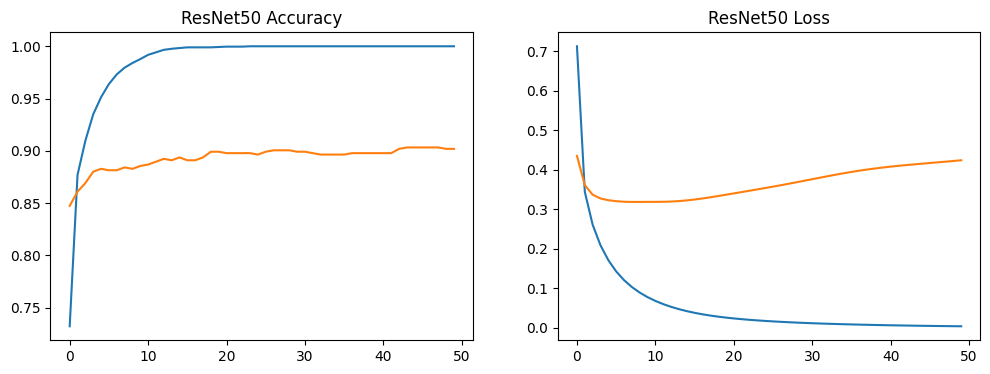

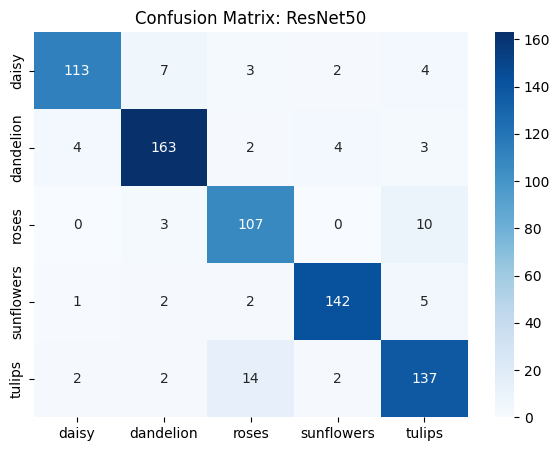

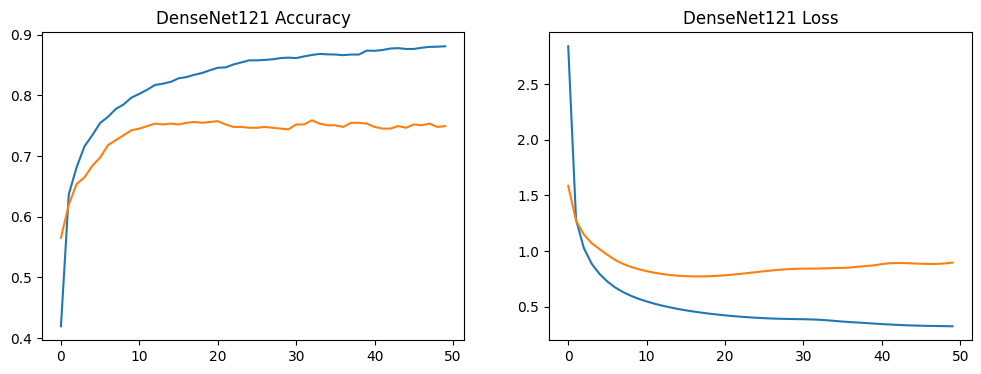

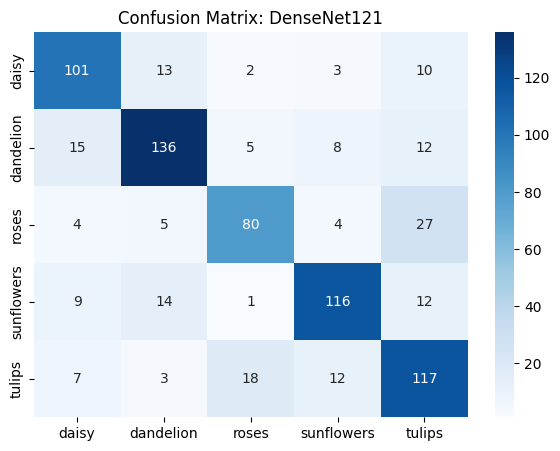

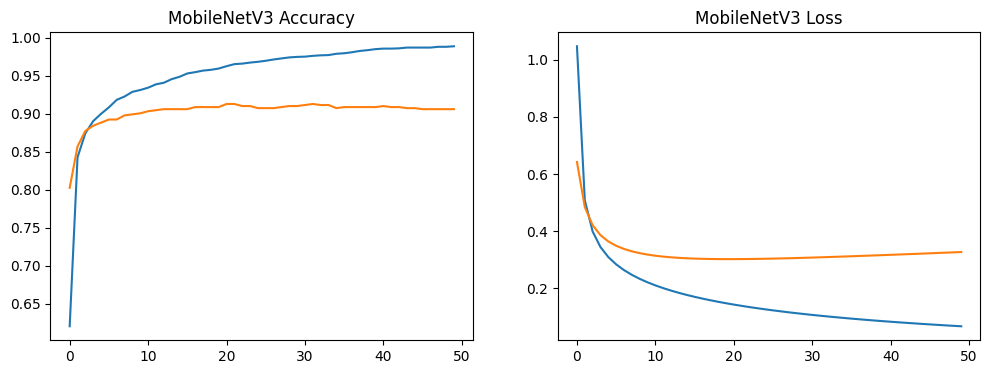

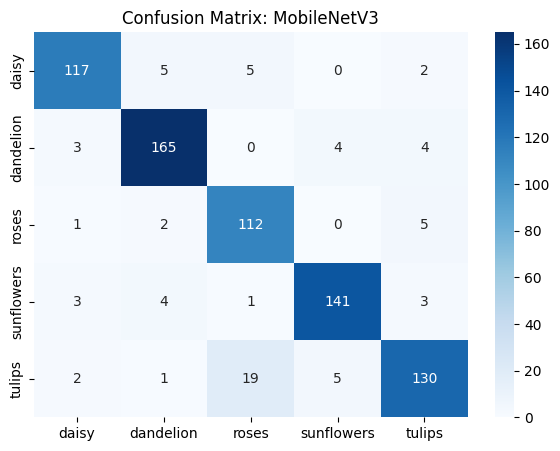

In [5]:
def evaluate_model(name):
    history = histories[name]
    model = trained_models[name]

    # 1. Performance Graphs (Loss and Accuracy)
    acc, val_acc = history.history['accuracy'], history.history['val_accuracy']
    loss, val_loss = history.history['loss'], history.history['val_loss']

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Train'); plt.plot(val_acc, label='Val'); plt.title(f'{name} Accuracy')
    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Train'); plt.plot(val_loss, label='Val'); plt.title(f'{name} Loss')
    plt.show()

    # 2. Confusion Matrix
    y_true, y_pred = [], []
    for imgs, labels in val_ds:
        y_true.extend(labels.numpy())
        y_pred.extend(np.argmax(model.predict(imgs, verbose=0), axis=1))

    plt.figure(figsize=(7, 5))
    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='g', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix: {name}'); plt.show()

    # 3. Calculate mAP (Precision macro average)
    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    return report['macro avg']['precision']

mAPs = {name: evaluate_model(name) for name in model_names}

Step 4: Visualize Top 5 Successes and Top 5 Failures

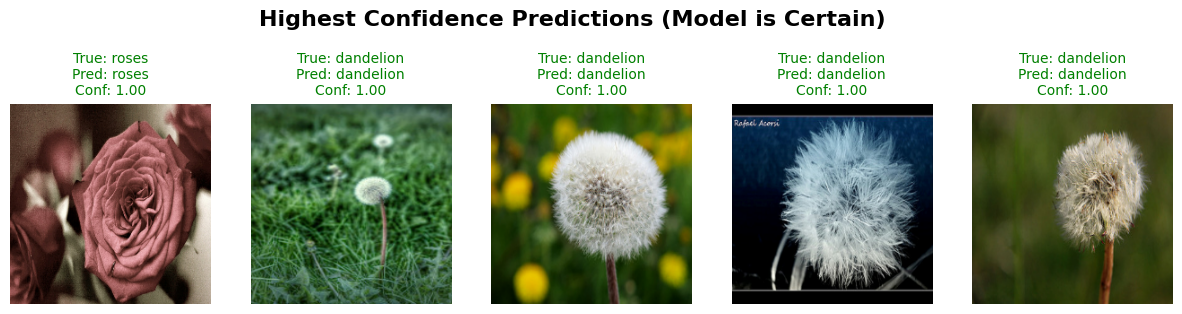

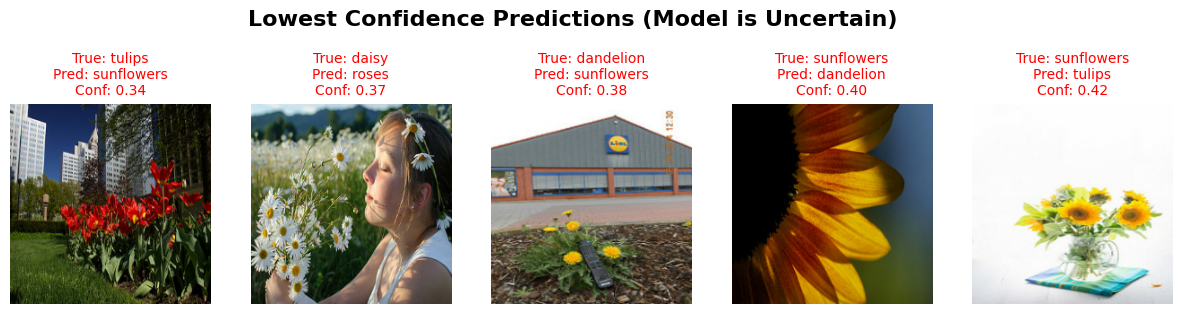

In [14]:
def visualize_confidence(model, dataset, class_names):
    images_list, labels_list, probs_list, preds_list = [], [], [], []

    # Take a few batches from validation to find examples
    for images, labels in dataset.take(10):
        preds = model.predict(images, verbose=0)
        for i in range(len(images)):
            images_list.append(images[i])
            labels_list.append(labels[i])
            probs_list.append(np.max(preds[i]))
            preds_list.append(np.argmax(preds[i]))

    probs_array = np.array(probs_list)
    sorted_indices = np.argsort(probs_array)

    # Identify Top 5 and Bottom 5
    top_5 = sorted_indices[-5:]
    bottom_5 = sorted_indices[:5]

    def plot_row(indices, title):
        plt.figure(figsize=(15, 4))
        plt.suptitle(title, fontsize=16, fontweight='bold')
        for i, idx in enumerate(indices):
            plt.subplot(1, 5, i + 1)
            plt.imshow(images_list[idx].numpy().astype("uint8"))

            true_label = class_names[labels_list[idx]]
            pred_label = class_names[preds_list[idx]]
            conf = probs_list[idx]

            color = 'green' if true_label == pred_label else 'red'
            plt.title(f"True: {true_label}\nPred: {pred_label}\nConf: {conf:.2f}", color=color, fontsize=10)
            plt.axis("off")
        plt.show()

    plot_row(top_5, "Highest Confidence Predictions (Model is Certain)")
    plot_row(bottom_5, "Lowest Confidence Predictions (Model is Uncertain)")

# winning model: MobileNetV3
visualize_confidence(trained_models['MobileNetV3'], val_ds, class_names)

Step 5: Final Comparison Table (For Conclusion)

In [9]:
# 1. Comparison Table
summary = []
for name in model_names:
    summary.append({
        'Model': name,
        'Accuracy': histories[name].history['val_accuracy'][-1],
        'mAP': mAPs[name],
        'Time (s)': training_times[name],
        'Params': trained_models[name].count_params()
    })
print("\n--- FINAL COMPARISON TABLE ---")
print(pd.DataFrame(summary))

# 2. Highest 5 vs Lowest 5 (Example for the best model)
def show_top_low(model, dataset):
    imgs, labels, preds, probs = [], [], [], []
    for i, l in dataset.take(3):
        p = model.predict(i, verbose=0)
        imgs.extend(i.numpy()); labels.extend(l.numpy())
        preds.extend(np.argmax(p, axis=1)); probs.extend(np.max(p, axis=1))

    indices = np.argsort(probs)
    # Plotting code would go here to show Top 5 (indices[-5:]) and Bottom 5 (indices[:5])

# Run this for your best model
show_top_low(trained_models['DenseNet121'], val_ds)


--- FINAL COMPARISON TABLE ---
         Model  Accuracy       mAP    Time (s)    Params
0     ResNet50  0.901907  0.901362  465.034684  23597957
1  DenseNet121  0.749319  0.752236  461.417437   7042629
2  MobileNetV3  0.905995  0.904214   89.263511    942005


<h1>Conclusion<h1/>

MobileNetV3 is clearly the best-suited model for this flower classification task.<br><br>

Final Conclusion: The Winning Model
The evaluation shows that MobileNetV3 provides the most optimal balance across all performance metrics.

Accuracy & mAP: MobileNetV3 achieved the highest Accuracy (0.906) and the highest mAP (0.904), slightly outperforming the ResNet50.

Parameters : It is the most efficient model by a massive margin, with only 942,005 parameters compared to ResNet50’s 23.5 million. This indicates a highly optimized architecture for feature extraction.

Training Time (Efficiency): It is the fastest to train, taking only 89 seconds, nearly around 5 times faster than both ResNet50 and DenseNet121. <br><br>

<strong>While ResNet50 performed well, its high computational cost (large parameters and long training time) makes it less ideal. DenseNet121 underperformed significantly in accuracy (74.9%) for this specific dataset. MobileNetV3 is recommended as it delivers superior precision with the lowest hardware demand, making it perfect for real-world deployment on mobile or edge devices for plant identification.<strong>